# Manipulation algorithm
This notebook will apply Algorithm 1 to a given profile of voters and candidates. A notebook format is used to provide commentary and illustrate step-by-step the process in the algorithm. 

In [1]:
#Key package imports
from itertools import permutations
import spatialGeneration
import itertools
import csv
import copy
import math
import matplotlib.pyplot as plt
import time

In [2]:
def setup():
    """setup()
    Takes the number of candidates, current voter rankings and coalition size.
    Creates a dictionary with the current votes for each candidate, and a list
    of potential elimination orders."""

    # list of ordered votes that we already know about
    """voter1 = {"A":1, "B": 2, "C": 3, "D": 4}
    voter2 = {"A":3, "B": 1, "C": 2, "D": 4}
    voter3 = {"A":1, "B": 2, "C": 3, "D": 4}
    voting_array = [voter1,voter2,voter3]"""
    
    voting_array = []
    #read csv for list of ordered votes that we already know about
    #with open("Exports/Export1678356411.497025.csv","r",newline='\n') as file:
    #    reader = csv.reader(file, delimiter=',')
    #    candidates = next(reader)
    #    #print(candidates)
    #    number_of_cands = len(candidates)
    #    for row in reader:
            #print(row)
    #        Vote = dict(zip(candidates,[int(i) for i in row]))
    #        voting_array.append(Vote)
            #print(voting_array)
    voting_array = copy.deepcopy(gen_Ranking)
    candidates = copy.deepcopy(gen_Candidates)
    #voting_array.pop(0) #necessary to delete headers
    #print(voting_array)
    candidates_and_votes = tally_votes(voting_array, candidates)

    # potential orders of elimination of candidates
    elimination_orders= []
    # Get permutations of n-1 candidates
    cand = list(candidates_and_votes.keys())
    perms_of_candidates = permutations(cand[0:len(candidates)-1])
    for i in perms_of_candidates:
        x = list(i)+[cand[-1]]
        elimination_orders.append(x)
    #print("orders: ",elimination_orders)
    #print(candidates_and_votes,voting_array)
    return candidates_and_votes, elimination_orders, voting_array, candidates

In [3]:
def tally_votes(v_array, candidates):
    # the candidates and the number of 1st choice votes they have
    candidates_and_votes = {candidates[i]:0 for i in range(0,len(candidates))}
    #print(candidates_and_votes)
    
    # add each voter's current 1st choice to the voting_array
    #print(voting_array)
    for voter in v_array:
        #print(voter)
        for key in voter:
            if voter[key]==1:
                candidates_and_votes[key]+=1
    return(candidates_and_votes)

In [4]:
def remove_orders(unsuccesful_start):
    elimination_orders_remove = []
    k = len(unsuccesful_start) 
    copy = elimination_orders.copy()
    for i in copy:
        if i[0:k] == unsuccesful_start:
            elimination_orders.remove(i)

In [5]:
def check_order(candidates_and_votes, order, col_size, voting_array, candidates):
    coalition_size = copy.deepcopy(col_size)
    voting_array_c = copy.deepcopy(voting_array)
    #print("HERE",candidates_and_votes)
    coalition_votes = []
    coalition_store = []
    dic__coalition_votes = []
    eliminated_candidates = []
    candidates_remaining = copy.deepcopy(candidates)
    for i in range(0,coalition_size):
        coalition_votes.append([])
    count = 1
    # copy of candidates and votes
    variable_votes = dict(candidates_and_votes)
    for i in order:
        eliminated_candidates.append(i)
        for j in order[order.index(i)+1:]:
            # compute votes required for j to beat i
            votes_req = int(variable_votes[i]) - int(variable_votes[j]) + 1
            # check that difference is positive
            if votes_req > 0:
                if len(coalition_votes) >= votes_req: # check if coalition size >= votes required to make j beat i
                    variable_votes[j] += votes_req
                    # decrease the amount of votes we can maniplulate this round
                    for c in range(0,votes_req):
                        coalition_votes[0].append(j)
                        coalition_store.append(coalition_votes[0])
                        coalition_votes.remove(coalition_votes[0])

                else:
                    # coalition was too small
                    remove_orders(eliminated_candidates)
                    #print("Elimination order is impossible", order)
                    return "fail","fail"
                    #return [], ord
        candidates_remaining.remove(i)
        if count <= len(order): # no point in doing the very last step of redistrbuting
            for en, voter in enumerate(voting_array_c):
                # Changes any first preference votes to the next available candidate in their preference order
                if voter[i] == 1:
                    voting_array_c[en] = {key: voter[key]-1 for key in voter}
        
                else:
                    # Eliminate candidate i from everyone elses list   
                    voting_array_c[en][i]=0                            
                    for key, value in voter.items():
                        """
                        print("i:",i," ",type(i),"\n",
                              "voter:",voter," ",type(voter),
                              "key:",key," ",type(key),"\n",
                              "value:",value, " ", type(key))"""
                        if int(value) > int(voter[i]):
                            voting_array_c[en][key] += -1
                count +=1
        #print(coalition_store)
        for b in coalition_store:
            if list(set(b).intersection(set(candidates_remaining))) == []:
                coalition_votes.insert(0,b)
                coalition_store.remove(b)
            # voters in coalitions next spot available to be filled
            
            
    coalition_votes += coalition_store
    #print("Successful Manipulation: ", ord)
    for v in coalition_votes:
        
        back_ord = order[::-1]
        #print("BACK ORD:",back_ord)
        dif = list(sorted(set(back_ord) - set(v), key=order.index))
        #print("V:",v)
        v += dif[::-1]
        #print("V+dif:",v)
        #print("NEW DICT:",{key: value+1 for value, key in enumerate(v)})
        dic__coalition_votes.append({key: value+1 for value, key in enumerate(v)})
        #print(order)
        #print({key: value+1 for value, key in enumerate(v)})
    return dic__coalition_votes, order

In [6]:
def check_manipulation(votes, k, candidates):
    all_votes = votes
    #print("CHECK MANIPULATION OF: ")
    # loop over number of eliminations (n-1 candidates)
    for i in range(0,k-1):
        #print(candidates)
        c_and_v = tally_votes(all_votes, candidates)
        #print("\n c_and_v: ",c_and_v)
        # there can't be ties by construction 
        # needs changing to elimate all candidates with votes = 0 / minimum, and change to while loop (while not just one candidate left with none-zero votes - what if tie?)
        if i == 0:
            elim_cand = min(c_and_v, key=c_and_v.get) #get candidate with least 1st choice votess
        else:
            elim_cand = min(x for x in c_and_v if  c_and_v[x] != 0)
        for en, vote_dict in enumerate(all_votes):
            #print("before", vote_dict)
            #print(elim_cand)
            # Changes any first preference votes to the next available candidate in their preference order
            if vote_dict[elim_cand] == 1:
                all_votes[en] = {key: vote_dict[key]-1 for key in vote_dict}
                all_votes[en].pop(elim_cand)
            else:
                # Eliminate candidate i from everyone elses list
                #all_votes[en][elim_cand] = 0
                for key, value in vote_dict.items():
                    if value > vote_dict[elim_cand]:
                        all_votes[en][key] += -1
                all_votes[en].pop(elim_cand)
           # print("after", all_votes[en])
        candidates.remove(elim_cand)
    #print("CANDIDATES",candidates)
    c_and_v = tally_votes(all_votes, candidates)
    #print("\n c_and_v: ",c_and_v)  
    #print(c_and_v,"\n")

    return (max(c_and_v, key=c_and_v.get))


In [7]:
#setup()

In [8]:
#coalition_array = []
#candidates_and_votes, elimination_orders, voting_array,candidates = setup()
#coalition_size = 2000

#for order in elimination_orders:
#    a,b = check_order(candidates_and_votes, order, coalition_size, voting_array,candidates)
#    #print("a: ",a)
#    #print("b: ",b)
#    #coalition_array.append([a,b])
#    if b != "fail":
#        y, yy, yyy,yyyy = setup()
#        check_votes = yyy + a
#       winner = check_manipulation(check_votes,len(yyyy),yyyy)
#        print(b, winner)

In [9]:
#gen_Ranking,gen_Candidates = spatialGeneration.returnRankings(5,100)

# Varying $\mathcal{K}$

In [10]:
gen_Ranking, gen_Candidates = spatialGeneration.returnRankings(5,100)

In [11]:
candidates_and_votes, elimination_orders, va, candidates = setup()
#coalition_size = 490
#MR = 0
def Cal_MR_K(col):
    MR = 0
    candidates_and_votes, elimination_orders, va, candidates = setup()
    for order in elimination_orders:
        a,b = check_order(candidates_and_votes, order, col, va, gen_Candidates)
        if a != "fail":
            MR += 1
    return MR/(math.factorial(len(gen_Candidates)-1))

24


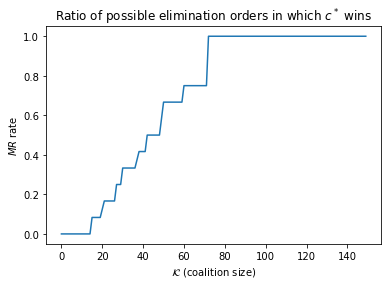

In [12]:
print(math.factorial(len(gen_Candidates)-1))

store = []
for r in range(0,150):
    #candidates_and_votes, elimination_orders, va, candidates = setup()
    store.append(Cal_MR_K(r))
#print(elimination_orders)
plt.plot(range(0,150),store)
plt.ylabel("$MR$ rate")
plt.xlabel("$\mathcal{K}$ (coalition size)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()

0
Generation successful. Time elapsed 0.1
1
Generation successful. Time elapsed 1.0
2
Generation successful. Time elapsed 2.0
3
Generation successful. Time elapsed 3.0
4
Generation successful. Time elapsed 4.0
5
Generation successful. Time elapsed 5.0
6
Generation successful. Time elapsed 6.0
7
Generation successful. Time elapsed 6.9
8
Generation successful. Time elapsed 7.9
9
Generation successful. Time elapsed 8.8
10
Generation successful. Time elapsed 9.8
11
Generation successful. Time elapsed 10.7
12
Generation successful. Time elapsed 11.7
13
Generation successful. Time elapsed 12.6
14
Generation successful. Time elapsed 13.6
15
Generation successful. Time elapsed 14.6
16
Generation successful. Time elapsed 15.6
17
Generation successful. Time elapsed 16.5
18
Generation successful. Time elapsed 17.5
19
Generation successful. Time elapsed 18.5


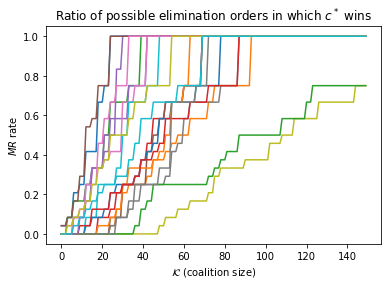

In [13]:
START = time.time()
stores = []
runs=20
for j in range(0,runs):
    print(j)
    gen_Ranking, gen_Candidates = spatialGeneration.returnRankings(5,100)
    print("Generation successful. Time elapsed",round(time.time()-START,1))
    candidates_and_votes, elimination_orders, va, candidates = setup()
    def Cal_MR_K(col):
        MR = 0
        candidates_and_votes, elimination_orders, va, candidates = setup()
        for order in elimination_orders:
            a,b = check_order(candidates_and_votes, order, col, va, gen_Candidates)
            if a != "fail":
                MR += 1
        return MR/(math.factorial(len(gen_Candidates)-1))

    store = []
    for r in range(0,150):
        #candidates_and_votes, elimination_orders, va, candidates = setup()
        if r%3==0:
            store.append(Cal_MR_K(r))
            #print("Run: ",j,"of",runs, "k: ",r, "Time elapsed: ", round(time.time()-START,1))
        else:
            store.append(store[-1])
    
    
    stores.append(store)
    plt.plot(range(0,150),store)
    
plt.ylabel("$MR$ rate")
plt.xlabel("$\mathcal{K}$ (coalition size)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()

In [14]:
def writeCsv():
    for k in range(13):
        csv_file = "Exports/C9V100/C9V100_"+str(k)+".csv"
        with open(csv_file, 'w',newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(stores[k])

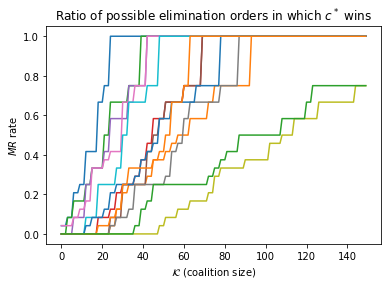

In [15]:
for i in range(0,13):
    plt.plot(range(0,150),stores[i])    
plt.ylabel("$MR$ rate")
plt.xlabel("$\mathcal{K}$ (coalition size)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()

# Varying $\mathcal{V}$

In [ ]:
#Successively pop elements from the voter-list, gen_Ranking 

voters = 1000
K=int(0.6*voters)
runs=20
START = time.time()

for i in range(runs):
    stores = []

    gen_Ranking, gen_Candidates = spatialGeneration.returnRankings(7,voters)
    print("Generation",i," successful. Time elapsed",round(time.time()-START,1))

    num_voters = len(gen_Ranking)


    store = []

    for k in range(0,int(num_voters*0.9)):
        gen_Ranking.pop(0)
        if k%1==0:
            def Cal_MR_K(col):
                MR = 0
                candidates_and_votes, elimination_orders, va, candidates = setup()
                for order in elimination_orders:
                    a,b = check_order(candidates_and_votes, order, col, va, gen_Candidates)
                    if a != "fail":
                        MR += 1
                return MR/(math.factorial(len(gen_Candidates)-1))
            store.append(Cal_MR_K(K))
            print("Run: ",k,"of",int(num_voters*0.9), "Time elapsed: ", round(time.time()-START,1))
        else:
            store.append(store[-1])

    
    store.reverse
    plt.plot(range(int(num_voters*0.1),num_voters),store[::-1])#reverse array so V and MR line up, as we popped going backwards
    stores.append(store)
plt.ylabel("$MR$ rate")
plt.xlabel("$|\mathcal{V}|$ (number of votes)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()  


Generation 0  successful. Time elapsed 0.6
Run:  0 of 900 Time elapsed:  6.7
Run:  1 of 900 Time elapsed:  12.8
Run:  2 of 900 Time elapsed:  18.7
Run:  3 of 900 Time elapsed:  24.5
Run:  4 of 900 Time elapsed:  30.4
Run:  5 of 900 Time elapsed:  36.2
Run:  6 of 900 Time elapsed:  42.1
Run:  7 of 900 Time elapsed:  47.9
Run:  8 of 900 Time elapsed:  53.7
Run:  9 of 900 Time elapsed:  59.6
Run:  10 of 900 Time elapsed:  65.4
Run:  11 of 900 Time elapsed:  71.2
Run:  12 of 900 Time elapsed:  77.1
Run:  13 of 900 Time elapsed:  82.9
Run:  14 of 900 Time elapsed:  88.6
Run:  15 of 900 Time elapsed:  94.4
Run:  16 of 900 Time elapsed:  100.2
Run:  17 of 900 Time elapsed:  106.0
Run:  18 of 900 Time elapsed:  111.7
Run:  19 of 900 Time elapsed:  117.5
Run:  20 of 900 Time elapsed:  123.3
Run:  21 of 900 Time elapsed:  129.0
Run:  22 of 900 Time elapsed:  134.7
Run:  23 of 900 Time elapsed:  140.5
Run:  24 of 900 Time elapsed:  146.2
Run:  25 of 900 Time elapsed:  151.9
Run:  26 of 900 Time e

Run:  217 of 900 Time elapsed:  1178.1
Run:  218 of 900 Time elapsed:  1183.0
Run:  219 of 900 Time elapsed:  1187.8
Run:  220 of 900 Time elapsed:  1192.6
Run:  221 of 900 Time elapsed:  1197.5
Run:  222 of 900 Time elapsed:  1202.4
Run:  223 of 900 Time elapsed:  1207.4
Run:  224 of 900 Time elapsed:  1212.5
Run:  225 of 900 Time elapsed:  1217.5
Run:  226 of 900 Time elapsed:  1222.6
Run:  227 of 900 Time elapsed:  1227.6
Run:  228 of 900 Time elapsed:  1232.7
Run:  229 of 900 Time elapsed:  1237.7
Run:  230 of 900 Time elapsed:  1242.7
Run:  231 of 900 Time elapsed:  1247.8
Run:  232 of 900 Time elapsed:  1252.8
Run:  233 of 900 Time elapsed:  1257.8
Run:  234 of 900 Time elapsed:  1262.8
Run:  235 of 900 Time elapsed:  1267.8
Run:  236 of 900 Time elapsed:  1272.8
Run:  237 of 900 Time elapsed:  1277.8
Run:  238 of 900 Time elapsed:  1282.8
Run:  239 of 900 Time elapsed:  1287.8
Run:  240 of 900 Time elapsed:  1292.8
Run:  241 of 900 Time elapsed:  1297.8
Run:  242 of 900 Time ela

Run:  428 of 900 Time elapsed:  2119.2
Run:  429 of 900 Time elapsed:  2123.2
Run:  430 of 900 Time elapsed:  2127.3
Run:  431 of 900 Time elapsed:  2131.3
Run:  432 of 900 Time elapsed:  2135.4
Run:  433 of 900 Time elapsed:  2139.5
Run:  434 of 900 Time elapsed:  2143.6
Run:  435 of 900 Time elapsed:  2147.7
Run:  436 of 900 Time elapsed:  2151.8
Run:  437 of 900 Time elapsed:  2155.9
Run:  438 of 900 Time elapsed:  2160.0
Run:  439 of 900 Time elapsed:  2164.0
Run:  440 of 900 Time elapsed:  2168.1
Run:  441 of 900 Time elapsed:  2172.2
Run:  442 of 900 Time elapsed:  2176.3
Run:  443 of 900 Time elapsed:  2180.3
Run:  444 of 900 Time elapsed:  2184.3
Run:  445 of 900 Time elapsed:  2188.4
Run:  446 of 900 Time elapsed:  2192.5
Run:  447 of 900 Time elapsed:  2196.5
Run:  448 of 900 Time elapsed:  2200.6
Run:  449 of 900 Time elapsed:  2204.7
Run:  450 of 900 Time elapsed:  2208.7
Run:  451 of 900 Time elapsed:  2212.7
Run:  452 of 900 Time elapsed:  2216.7
Run:  453 of 900 Time ela

1
